In [1]:
import cv2 as cv
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
def saveFrame(image, points, directory, filename):
    bgrImage = cv.cvtColor(image, cv.COLOR_RGB2BGR)
    closedPoints = np.append(points, [points[0]], axis=0)
    for start, end in zip(closedPoints[:-1], closedPoints[1:]):
        bgrImage = cv.line(bgrImage, tuple(start), tuple(end), color=(255, 0, 0), thickness=1)
    cv.imwrite(f'{directory}/{filename}.jpg', bgrImage)

def createVideoFromFrames(directory, numFrames, outputFilename='outputVideo.mp4'):
    frames = [cv.imread(f'{directory}/{i}.jpg') for i in range(numFrames)]
    height, width, _ = frames[0].shape
    fourcc = cv.VideoWriter_fourcc(*'mp4v')
    video = cv.VideoWriter(outputFilename, fourcc, 5, (width, height))
    for frame in frames:
        video.write(frame)
    video.release()

def generateInitialPoints(imageSize, center, radius, numPoints):
    height, width = imageSize[:2]
    angles = np.linspace(0, 2 * np.pi, numPoints)
    xPoints = center[0] + np.round(radius[0] * np.cos(angles)).astype(int)
    yPoints = center[1] + np.round(radius[1] * np.sin(angles)).astype(int)
    xPoints = np.clip(xPoints, 0, width - 1)
    yPoints = np.clip(yPoints, 0, height - 1)
    return np.vstack((xPoints, yPoints)).T

def computeImageGradient(image):
    edges = cv.Canny(image, 100, 255).astype(float)
    blurred = cv.GaussianBlur(edges, (21, 21), 0)
    normalized = blurred / np.max(blurred)
    return normalized

def computeInternalEnergy(points, alpha):
    closedPoints = np.append(points, [points[0]], axis=0)
    differences = np.diff(closedPoints, axis=0) ** 2
    elasticEnergy = differences[:, 0] + differences[:, 1]
    meanDistance = np.mean(np.sqrt(elasticEnergy))
    internalEnergy = np.mean((elasticEnergy - alpha * meanDistance) ** 2)
    return internalEnergy, np.mean(elasticEnergy), meanDistance

def computeExternalEnergy(gradient, points):
    intensityValues = gradient[points[:, 1], points[:, 0]]
    externalEnergy = -np.sum(intensityValues)
    return externalEnergy

def computeTotalEnergy(image, gradient, points, alpha, lambda_):
    internalEnergy, _, _ = computeInternalEnergy(points, alpha)
    externalEnergy = computeExternalEnergy(gradient, points)
    totalEnergy = internalEnergy + lambda_ * externalEnergy
    return totalEnergy, internalEnergy, externalEnergy

def optimizeContour(image, gradient, points, alpha, lambda_, searchRadius):
    margin = searchRadius // 2
    height, width = image.shape
    initialEnergy, _, _ = computeTotalEnergy(image, gradient, points, alpha, lambda_)
    optimizedPoints = points.copy()
    tempPoints = points.copy()

    for i, point in enumerate(points):
        xRange = np.clip([point[0] - margin, point[0] + margin], 0, width - 1).astype(int)
        yRange = np.clip([point[1] - margin, point[1] + margin], 0, height - 1).astype(int)

        bestEnergy = initialEnergy
        for x in range(xRange[0], xRange[1] + 1):
            for y in range(yRange[0], yRange[1] + 1):
                tempPoints[i] = [x, y]
                newEnergy, _, _ = computeTotalEnergy(image, gradient, tempPoints, alpha, lambda_)
                if newEnergy < bestEnergy:
                    optimizedPoints[i] = [x, y]
                    bestEnergy = newEnergy
        tempPoints[i] = point

    return optimizedPoints

def activeContourModel(image, grayImage, initialPoints, alpha=1, lambda_=0, searchRadius=5, iterations=10):
    gradient = computeImageGradient(grayImage)
    points = initialPoints
    resultsDir = 'contourResults'
    if not os.path.exists(resultsDir):
        os.makedirs(resultsDir)
    
    for i in range(iterations):
        points = optimizeContour(grayImage, gradient, points, alpha, lambda_, searchRadius)
        saveFrame(image, points, resultsDir, i)
        printProgressBar(i + 1, iterations)
    
    points = np.append(points, [points[0]], axis=0)
    return points

def printProgressBar(iteration, total, length=50, fill='█', printEnd="\r"):
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\rProgress: |{bar}| {percent}% Complete', end=printEnd)
    if iteration == total:
        print()


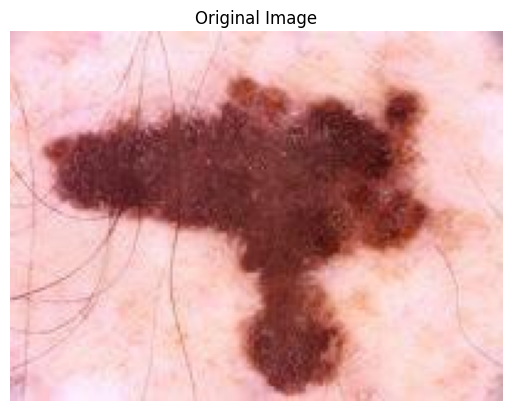

In [3]:
image = cv.imread('melanoma.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
grayScaleImage = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

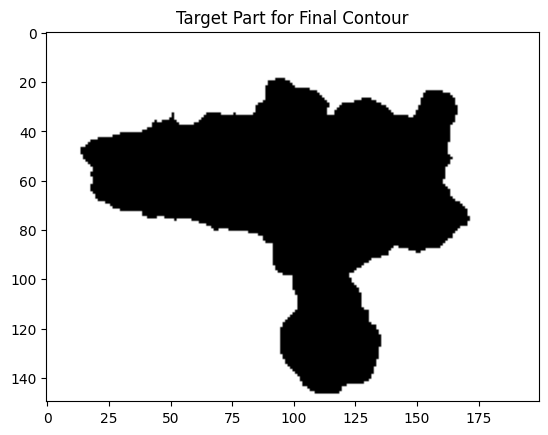

In [4]:
targetPart = grayScaleImage.copy()
targetPart = cv.GaussianBlur(targetPart, (5, 5), 0)
ret, targetPart = cv.threshold(targetPart, 150, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
plt.imshow(targetPart, cmap='gray')
plt.title('Target Part for Final Contour')
plt.show()

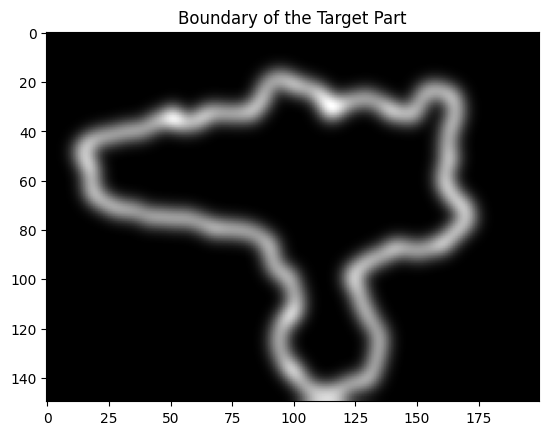

In [5]:
gradientImage = computeImageGradient(targetPart)
plt.imshow(gradientImage, cmap='gray')
plt.title('Boundary of the Target Part')
plt.show()

In [8]:
nIter = 150
initialPoints = generateInitialPoints(image.shape[:2], center=[100, 70], radius=(70, 70), numPoints=200)
points = activeContourModel(image, targetPart, initialPoints, alpha=1e-4, lambda_=1e9, searchRadius=5, iterations=nIter)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


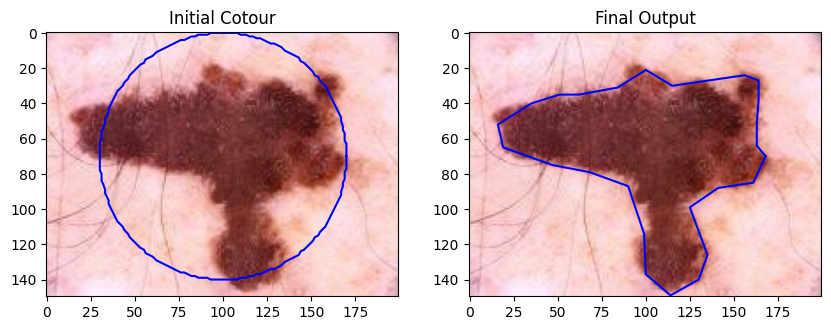

In [9]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Initial Cotour')
plt.plot(initialPoints[:, 0], initialPoints[:, 1], 'b-')
plt.subplot(1, 2, 2)
plt.title('Final Output')
plt.imshow(image)
plt.plot(points[:, 0], points[:, 1], 'b-')
plt.show()

In [10]:
createVideoFromFrames('contourResults', nIter)

## By checking the outputs it is obvious that the output does not change from 93th itteration